In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from utils.viewer import show_batch
import time
from vae_models import VAE_CONV_NeuralModel
from graphviz import Digraph
from torchviz import make_dot, make_dot_from_trace
import matplotlib.pyplot as plt
import numpy as np
from multiple_attacks import *
from mnist_classifier import NeuralModel, test_model

In [2]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
train_set, test_set = data_loader.get_data()

In [4]:
class VAEEClassifier(nn.Module):
    def __init__(self, beta):
        super().__init__()
        
        self.vae = VAE_CONV_NeuralModel()
        self.vae.load_state_dict(torch.load("models/trained_CONV_vae_B="+str(beta)))
        
        self.classifier_part = self.encoder = nn.Sequential(

            nn.Conv2d(16, 14, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(14),
            nn.ReLU(inplace=True),

            nn.Conv2d(14, 12, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(12, 10, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(10),
            #nn.linear(inplace=True),
            
        )
        
        self.fc = nn.Linear(10 * 1 * 1, 10)
        # no_of_last_channels* kernel_H * kernel_W, output_from_fully_conncected 
    def forward(self, x):
        #with torch.no_grad():
        vaee_features = self.vae.get_latent(x)
        
        convolved = self.classifier_part(vaee_features)
        classification_logits = self.fc(convolved.view(convolved.size(0), -1))
        
        return  classification_logits
            

In [5]:
def train_model(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 15
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for batch in train_data:
            batch_images, batch_labels = batch
            
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            batch_output = model(batch_images)
            loss = criterion(batch_output, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [6]:

# torch.save(model.state_dict(), "models/trained_VAEEClassifier")

# model = VAEEClassifier()
# model.load_state_dict(torch.load("models/trained_VAEEClassifier"))
# model.to(device)


In [7]:
fgsms = []
pgds = []
ifgsms=[]
deepfools=[]
eps = .3
clean_accuracies =[]
batch_size = 512
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [8]:

for b in range (1,10):
    
    print("=*="*20)
    
    initial_classifier = VAEEClassifier(beta=b).to(device)
    model =  VAEEClassifier(beta=b).to(device)
    model = train_model(model, train_loader)
    
    
    testing_accuracy_before_attack = test_model(model, test_loader)
    
    print("test accuracy is: ", testing_accuracy_before_attack)
    clean_accuracies.append(testing_accuracy_before_attack)
    
    fgsms.append(attack(model, device, test_loader, fgsm, eps)[0])

    pgds.append(attack(model, device, test_loader, pgd, eps, 1e-2, 50)[0])

    ifgsms.append(attack(model, device, test_loader, pgd_linf, eps, 1e4, 50)[0])

    deepfools.append(attack(model, device, test_loader, pgd_l2, 1.3, eps, 50)[0])
    


=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
the loss after processing this epoch is:  0.4084756076335907
the loss after processing this epoch is:  0.34742990136146545
the loss after processing this epoch is:  0.1055217981338501
the loss after processing this epoch is:  0.07335751503705978
the loss after processing this epoch is:  0.06892599910497665
the loss after processing this epoch is:  0.03971533477306366
the loss after processing this epoch is:  0.040640320628881454
the loss after processing this epoch is:  0.024752654135227203
the loss after processing this epoch is:  0.020920751616358757
the loss after processing this epoch is:  0.011799429543316364
the loss after processing this epoch is:  0.011993278749287128
the loss after processing this epoch is:  0.008363897912204266
the loss after processing this epoch is:  0.00971135962754488
the loss after processing this epoch is:  0.007609829306602478
the loss after processing this epoch is:  0.007704208139330149
tes

the loss after processing this epoch is:  0.059485647827386856
the loss after processing this epoch is:  0.05393235385417938
the loss after processing this epoch is:  0.05524209514260292
the loss after processing this epoch is:  0.05186339095234871
the loss after processing this epoch is:  0.05162819102406502
the loss after processing this epoch is:  0.048737600445747375
the loss after processing this epoch is:  0.05106785520911217
test accuracy is:  0.9923
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
the loss after processing this epoch is:  0.7341647148132324
the loss after processing this epoch is:  0.681914746761322
the loss after processing this epoch is:  0.11974668502807617
the loss after processing this epoch is:  0.09371203184127808
the loss after processing this epoch is:  0.10150396078824997
the loss after processing this epoch is:  0.08443253487348557
the loss after processing th

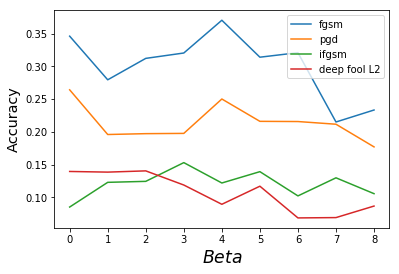

In [9]:
plt.plot(fgsms, label = 'fgsm')
plt.plot(pgds, label ="pgd")
plt.plot(ifgsms, label = 'ifgsm')
plt.plot(deepfools, label = 'deep fool L2')
plt.legend() 

plt.xlabel('$Beta$', size = 'xx-large', fontweight = 'demi')
plt.ylabel('Accuracy', size = 'x-large')
plt.savefig('figures/vaee_classifier.pdf', format='pdf', bbox_inches='tight', quality = 100)

plt.show()

In [10]:
print(pgds)

[0.2642, 0.196, 0.1973, 0.1977, 0.2502, 0.2161, 0.2158, 0.2117, 0.1771]


In [11]:
# accuracies = np.array(accuracies).T

# clean_accuracies = np.array(clean_accuracies).reshape(1,-1)
# print(clean_accuracies.shape)

# accuracies_diff = clean_accuracies - accuracies

# for eps, per_epsilon_diff in zip(epsilons,accuracies_diff):
#     plt.plot(per_epsilon_diff, label ='$\epsilon$ = '+str(eps))
# plt.legend( loc='upper right', bbox_to_anchor=(1.2,1))
# plt.xlabel('$B$', size = 'xx-large', fontweight = 'demi')
# plt.ylabel('Acc diff', size = 'x-large', fontweight = 'demi')

In [12]:
print(attack(model, device, test_loader, pgd, eps, 1e-2, 100)[0])

Projected Gradient Attack : 
0.0715


In [13]:
print(attack(model, device, test_loader, pgd, eps, 1e-4, 100)[0])

Projected Gradient Attack : 
0.9724
